In [18]:
import torch
from torch import nn
from torch.distributions import Poisson, Gamma
import matplotlib.pyplot as plt
import numpy as np
from einops import rearrange, repeat
import pytorch_lightning
import tqdm
import seaborn as sns

from case_studies.dc2_mdt.utils.reverse_markov_learning import RMLDiffusion
from case_studies.dc2_mdt.utils.resample import SigmoidSampler

In [ ]:
device = torch.device("cuda:6")
batch_size = 1024
val_batch_size = 30_000
training_time_steps = 1000
training_iters = 5000
val_iters = 10
ddim_steps = 10
ddim_eta = 0.0  # use 0.0 for better results when max_objects >= 2
log_freq = 500
seed = 1201023
pytorch_lightning.seed_everything(seed)

Seed set to 1201023


1201023

In [3]:
image_normalize_strategy = "linear_scale"

In [4]:
class ConstantLocsPrior:
    def __init__(self, low, high, offset):
        self.low = low
        self.high = high
        self.offset = offset

    def sample(self, sample_shape):
        mid_point = (self.low + self.high) / 2
        m = sample_shape[-1]
        mid_point = torch.stack([mid_point + self.offset * i for i in range(m)], dim=0)
        assert (mid_point <= self.high).all()
        return torch.ones(sample_shape[:-1]).unsqueeze(-1).unsqueeze(-1) * mid_point
    

class CatalogPrior:
    def __init__(
        self,
        num_objects: int,
        img_height: int,
        img_width: int,
        locs_offset: float,
        flux_alpha: float,
        flux_beta: float,
    ):
        self.num_objects = num_objects
        self.img_height = img_height
        self.img_width = img_width
        self.flux_prior = Gamma(torch.tensor(flux_alpha), 
                                torch.tensor(flux_beta))
        self.loc_prior = ConstantLocsPrior(torch.zeros(2), 
                                           torch.tensor((self.img_height, self.img_width)),
                                           offset=locs_offset)

    def sample(
        self,
        num_catalogs,
    ):
        fluxes = self.flux_prior.sample([num_catalogs, self.num_objects])  # (n_catalogs, m)
        locs = self.loc_prior.sample(
            [num_catalogs, self.num_objects]
        )  # (n_catalogs, m, 2)
        return {
            "count": torch.full((num_catalogs, ), fill_value=self.num_objects),
            "fluxes": fluxes, 
            "locs": locs
        }



class ImageSimulator(nn.Module):
    def __init__(
        self,
        img_height: int,
        img_width: int,
        num_objects: int,
        locs_offset: float,
        flux_alpha: float,
        flux_beta: float,
        psf_stdev: float,
        background_intensity: float,
    ):
        super().__init__()

        self.img_height = img_height
        self.img_width = img_width
        self.num_objects = num_objects

        self.psf_stdev = psf_stdev
        self.background_intensity = background_intensity

        self.catalog_prior = CatalogPrior(num_objects=num_objects,
                                          img_height=img_height,
                                          img_width=img_width,
                                          locs_offset=locs_offset,
                                          flux_alpha=flux_alpha,
                                          flux_beta=flux_beta)

        self.register_buffer("dummy_param", torch.zeros(0))
        self.register_buffer("psf_marginal_h",
                             (0.5 + torch.arange(self.img_height, dtype=torch.float32)).view(1, self.img_height, 1, 1))
        self.register_buffer("psf_marginal_w",
                             (0.5 + torch.arange(self.img_width, dtype=torch.float32)).view(1, 1, self.img_width, 1))

    @property
    def device(self):
        return self.dummy_param.device

    def psf(self, loc_h, loc_w):
        logpsf = -(
            (self.psf_marginal_h - loc_h.view(-1, 1, 1, self.num_objects)) ** 2
            + (self.psf_marginal_w - loc_w.view(-1, 1, 1, self.num_objects)) ** 2
        ) / (2 * self.psf_stdev ** 2)
        return torch.exp(logpsf - logpsf.logsumexp(dim=(1, 2), keepdim=True))
    
    def _generate(self, batch_size):
        tile_cat = self.catalog_prior.sample(num_catalogs=batch_size)
        tile_cat = {k: v.to(device=self.device) for k, v in tile_cat.items()}
        psf = self.psf(tile_cat["locs"][:, :, 0], tile_cat["locs"][:, :, 1])  # (b, h, w, m)
        source_intensities = (tile_cat["fluxes"].view(batch_size, 1, 1, self.num_objects) * psf).sum(dim=3)  # (b, h, w)
        total_intensities = source_intensities + self.background_intensity
        images = Poisson(total_intensities).sample()
        return {
            **tile_cat, 
            "psf": psf,
            "source_intensities": source_intensities,
            "total_intensities": total_intensities, 
            "images": images
        }
    
    def generate(self, batch_size, *, seed=None):
        if seed is not None:
            with torch.random.fork_rng(devices=["cpu", self.device]):
                torch.manual_seed(seed)
                output = self._generate(batch_size)
        else:
            output = self._generate(batch_size)
        return output

In [5]:
image_size = 4
num_objects = 1
background_intensity = 50.0
image_simulator = ImageSimulator(img_height=image_size, 
                                    img_width=image_size, 
                                    num_objects=num_objects, 
                                    locs_offset=0.5,
                                    flux_alpha=10.0,
                                    flux_beta=0.01,
                                    psf_stdev=1.0, 
                                    background_intensity=background_intensity).to(device=device)

In [6]:
class FourierMLP(nn.Module):
    def __init__(self, data_shape, num_layers, hidden_ch):
        super().__init__()
        self.data_shape = [data_shape]

        self.register_buffer(
            "timestep_coeff", torch.linspace(start=0.1, end=100, steps=hidden_ch)[None]
        )  # (1, hidden)
        self.timestep_phase = nn.Parameter(torch.randn(hidden_ch)[None])  # (1, hidden)
        self.input_embed = nn.Sequential(
            nn.Linear(int(np.prod(data_shape)), hidden_ch),
            nn.GELU(),
            nn.Linear(hidden_ch, hidden_ch)
        )
        self.timestep_embed = nn.Sequential(
            nn.Linear(2 * hidden_ch, hidden_ch),
            nn.GELU(),
            nn.Linear(hidden_ch, hidden_ch),
        )
        self.image_embed = nn.Sequential(
            nn.Linear(image_size * image_size * num_objects, hidden_ch),
            nn.GELU(),
            nn.Linear(hidden_ch, hidden_ch)
        )
        self.layers = nn.Sequential(
            nn.Linear(hidden_ch * 2 + int(np.prod(data_shape)), hidden_ch), 
            nn.GELU(),
            *[
                nn.Sequential(nn.Linear(hidden_ch, hidden_ch), nn.GELU())
                for _ in range(num_layers)
            ],
            nn.Linear(hidden_ch, int(np.prod(data_shape))),
        )

        self.vmap_timestep_embed = torch.vmap(self.timestep_embed.__call__, in_dims=1, out_dims=1, randomness="same")
        self.vmap_input_embed = torch.vmap(self.input_embed.__call__, in_dims=1, out_dims=1, randomness="same")
        self.vmap_layers = torch.vmap(self.layers.__call__, in_dims=1, out_dims=1, randomness="same")

    def forward(self, x, t, image, epsilon, is_training):
        if is_training:
            t = t.unsqueeze(-1)  # (b, m, 1)
            sin_embed_t = torch.sin(
                (self.timestep_coeff.unsqueeze(0) * t.float()) + self.timestep_phase.unsqueeze(0)
            )
            cos_embed_t = torch.cos(
                (self.timestep_coeff.unsqueeze(0) * t.float()) + self.timestep_phase.unsqueeze(0)
            )
            embed_t = self.vmap_timestep_embed(
                rearrange(torch.stack([sin_embed_t, cos_embed_t], dim=0), 
                          "d b m w -> b m (d w)")
            )  # (b, m, hidden)
            embed_xt = self.vmap_input_embed(x.flatten(2))  # (b, m, hidden)
            embed_image = self.image_embed(image.flatten(1))  # (b, hidden)
            embed_image = repeat(embed_image, "b hidden -> b m hidden", m=t.shape[1])
            out = self.vmap_layers(
                torch.cat([embed_xt + embed_t, embed_image, epsilon], dim=-1)
            )
            return out.view(x.shape)
        
        t = t.unsqueeze(-1)  # (b, 1)
        sin_embed_t = torch.sin(
            (self.timestep_coeff * t.float()) + self.timestep_phase
        )  # (b, hidden)
        cos_embed_t = torch.cos(
            (self.timestep_coeff * t.float()) + self.timestep_phase
        )
        embed_t = self.timestep_embed(
            rearrange(torch.stack([sin_embed_t, cos_embed_t], dim=0), 
                      "d b w -> b (d w)")
        )
        embed_xt = self.input_embed(x.flatten(1))
        embed_image = self.image_embed(image.flatten(1))
        out = self.layers(
            torch.cat([embed_xt + embed_t, embed_image, epsilon], dim=-1)
        )
        return out.view(x.shape)

In [7]:
training_diffusion = RMLDiffusion(num_timesteps=training_time_steps,
                                  num_sampling_steps=ddim_steps,
                                  m=64,
                                  lambda_=1.0,
                                  beta=0.5)
sampling_diffusion = training_diffusion
# schedule_sampler = create_named_schedule_sampler("uniform", training_diffusion)
# schedule_sampler = SpeedSampler(diffusion=training_diffusion,
#                                 lam=0.6,
#                                 k=5,
#                                 tau=700)
schedule_sampler = SigmoidSampler(training_diffusion, 0)
image_simulator = ImageSimulator(img_height=image_size,
                                 img_width=image_size,
                                 num_objects=num_objects,
                                 locs_offset=0.0,
                                 flux_alpha=10.0,
                                 flux_beta=0.01,
                                 psf_stdev=1.0,
                                 background_intensity=50.0).to(device=device)

In [8]:
my_net = FourierMLP(data_shape=[2,], 
                    num_layers=8, 
                    hidden_ch=256).to(device=device)
# my_net = SimpleMLP(layers=8, hidden_ch=256).to(device=device)
my_optimizer = torch.optim.Adam(my_net.parameters(), lr=1e-3, amsgrad=True)
my_scheduler = torch.optim.lr_scheduler.MultiStepLR(my_optimizer, milestones=[training_iters // 4 * 3], gamma=0.1)

In [9]:
max_flux_boundary = 2000.0
def encode_flux(flux: torch.Tensor):
    assert flux.min() >= 0.0
    flux = flux.clamp(max=max_flux_boundary)
    return (flux / max_flux_boundary) * 2 - 1

def decode_flux(flux_minus1_to_1: torch.Tensor):
    assert flux_minus1_to_1.min() >= -1.0 and flux_minus1_to_1.max() <= 1.0
    return (flux_minus1_to_1 + 1) / 2 * max_flux_boundary

In [10]:
my_net.train()
loss_record = []
shuffle_flux = lambda x: x[..., torch.randperm(x.shape[-1])]
shuffle_flux = torch.vmap(shuffle_flux, randomness="different")
for i in tqdm.tqdm(list(range(training_iters))):
    catalog = image_simulator.generate(batch_size)
    t, batch_sample_weights, batch_loss_weights = schedule_sampler.sample(batch_size, device=device)
    target_fluxes = catalog["fluxes"][:, 0:1]  # (b, 1)
    target_fluxes = torch.cat([target_fluxes, torch.zeros_like(target_fluxes)], dim=-1)  # (b, 2)
    target_fluxes = shuffle_flux(target_fluxes)
    input_image = catalog["images"]  # (b, h, w)
    match image_normalize_strategy:
        case "none":
            pass
        case "log":
            input_image = torch.log1p(input_image)
        case "linear_scale":
            input_image = input_image / 1000
        case _:
            raise NotImplementedError()
    train_loss_args = {
        "model": my_net,
        "x_start": encode_flux(target_fluxes),
        "t": t,
        "loss_weights": batch_loss_weights
    }
    loss = training_diffusion.training_losses(**train_loss_args, 
                                              model_kwargs={"image": input_image})["loss"]
    loss = (loss * batch_sample_weights).mean()
    loss_record.append(loss.item())
    my_optimizer.zero_grad()
    loss.backward()
    my_optimizer.step()
    my_scheduler.step()
    if (i + 1) % log_freq == 0:
        print(f"[{i + 1}/{training_iters}] loss: {loss.item():.3e}")

 10%|█         | 503/5000 [00:29<04:14, 17.70it/s]

[500/5000] loss: 9.481e-02


 20%|██        | 1003/5000 [00:57<03:48, 17.51it/s]

[1000/5000] loss: 9.090e-02


 30%|███       | 1503/5000 [01:26<03:20, 17.47it/s]

[1500/5000] loss: 8.527e-02


 40%|████      | 2003/5000 [01:54<02:51, 17.49it/s]

[2000/5000] loss: 8.152e-02


 50%|█████     | 2503/5000 [02:23<02:23, 17.44it/s]

[2500/5000] loss: 7.929e-02


 60%|██████    | 3003/5000 [02:52<01:53, 17.55it/s]

[3000/5000] loss: 8.162e-02


 70%|███████   | 3503/5000 [03:20<01:25, 17.41it/s]

[3500/5000] loss: 7.809e-02


 80%|████████  | 4003/5000 [03:49<00:57, 17.44it/s]

[4000/5000] loss: 7.544e-02


 90%|█████████ | 4503/5000 [04:18<00:28, 17.45it/s]

[4500/5000] loss: 7.734e-02


100%|██████████| 5000/5000 [04:46<00:00, 17.44it/s]

[5000/5000] loss: 8.022e-02


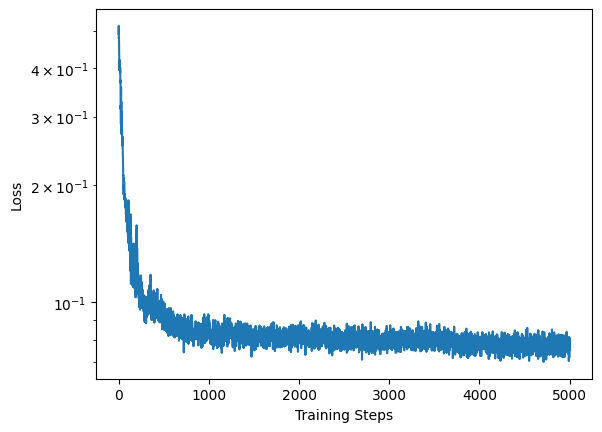

In [11]:
plt.plot(loss_record)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()

In [14]:
my_net.eval()
val_true_fluxes = None
val_est_fluxes = []
with torch.inference_mode():
    val_catalog = image_simulator.generate(batch_size=val_batch_size, 
                                           seed=seed)
    for i in tqdm.tqdm(list(range(val_iters))):
        target_fluxes = val_catalog["fluxes"][:, 0:1]  # (b, 1)
        if val_true_fluxes is None:
            val_true_fluxes = target_fluxes
        else:
            assert torch.allclose(val_true_fluxes, target_fluxes)
        input_image = val_catalog["images"]
        match image_normalize_strategy:
            case "none":
                pass
            case "log":
                input_image = torch.log1p(input_image)
            case "linear_scale":
                input_image = input_image / 1000
            case _:
                raise NotImplementedError()
        diffusion_sampling_config = {
            "model": my_net,
            "shape": (val_batch_size, 2),
            "clip_denoised": True,
            "model_kwargs": {"image": input_image}
        }
        sample = sampling_diffusion.ddim_sample_loop(**diffusion_sampling_config, eta=ddim_eta)
        val_est_fluxes.append(decode_flux(sample).cpu())
val_est_fluxes = torch.stack(val_est_fluxes, dim=0)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:01<00:00,  5.03it/s]


In [16]:
val_est_fluxes.shape, val_true_fluxes.shape

(torch.Size([10, 30000, 2]), torch.Size([30000, 1]))

In [36]:
val_true_fluxes = torch.cat([val_true_fluxes, torch.zeros_like(val_true_fluxes)], dim=-1)
val_true_fluxes = shuffle_flux(val_true_fluxes)

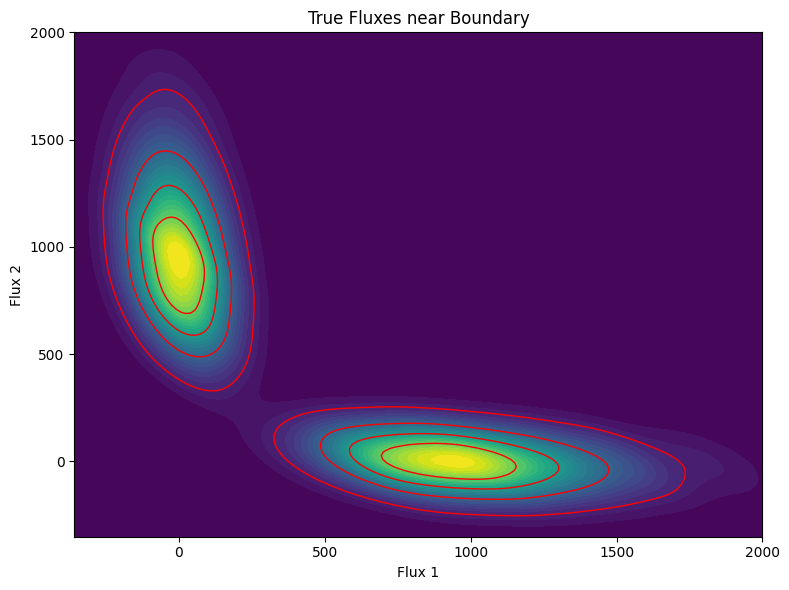

In [40]:
x = val_true_fluxes[..., 0].view(-1).cpu()
y = val_true_fluxes[..., 1].view(-1).cpu()
selected_indexes = torch.randperm(x.shape[0])[:10_000]
x = x[selected_indexes]
y = y[selected_indexes]
plt.figure(figsize=(8, 6))
sns.kdeplot(
    x=x, y=y,
    fill=True,
    levels=30,
    thresh=0.0,
    cmap="viridis"
)
sns.kdeplot(
    x=x, y=y,
    fill=False,
    levels=5,
    color="red",
    linewidths=1.0,
    thresh=1e-1,
)
plt.xlabel("Flux 1")
plt.ylabel("Flux 2")
plt.xlim(right=2000)
plt.ylim(top=2000)
plt.title("True Fluxes near Boundary")
plt.tight_layout()
plt.show()

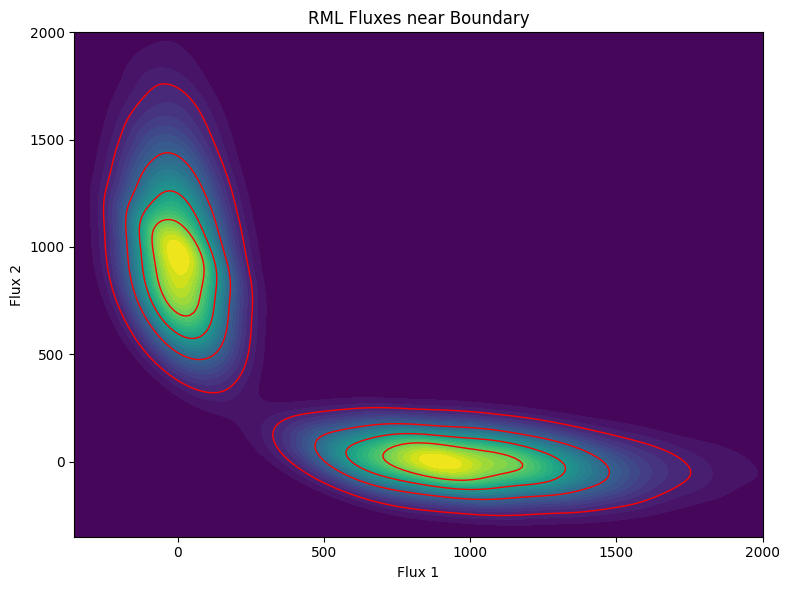

In [39]:
x = val_est_fluxes[..., 0].view(-1)
y = val_est_fluxes[..., 1].view(-1)
selected_indexes = torch.randperm(x.shape[0])[:10_000]
x = x[selected_indexes]
y = y[selected_indexes]
plt.figure(figsize=(8, 6))
sns.kdeplot(
    x=x, y=y,
    fill=True,
    levels=30,
    thresh=0.0,
    cmap="viridis"
)
sns.kdeplot(
    x=x, y=y,
    fill=False,
    levels=5,
    color="red",
    linewidths=1.0,
    thresh=1e-1,
)
plt.xlabel("Flux 1")
plt.ylabel("Flux 2")
plt.xlim(right=2000)
plt.ylim(top=2000)
plt.title("RML Fluxes near Boundary")
plt.tight_layout()
plt.show()